In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2


from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import warnings
import logging

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 200

random.seed(42)
np.random.seed(42)

logging.basicConfig(level=logging.INFO)

time: 777 ms (started: 2024-06-12 14:17:03 -07:00)


## Generate synthetic data

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

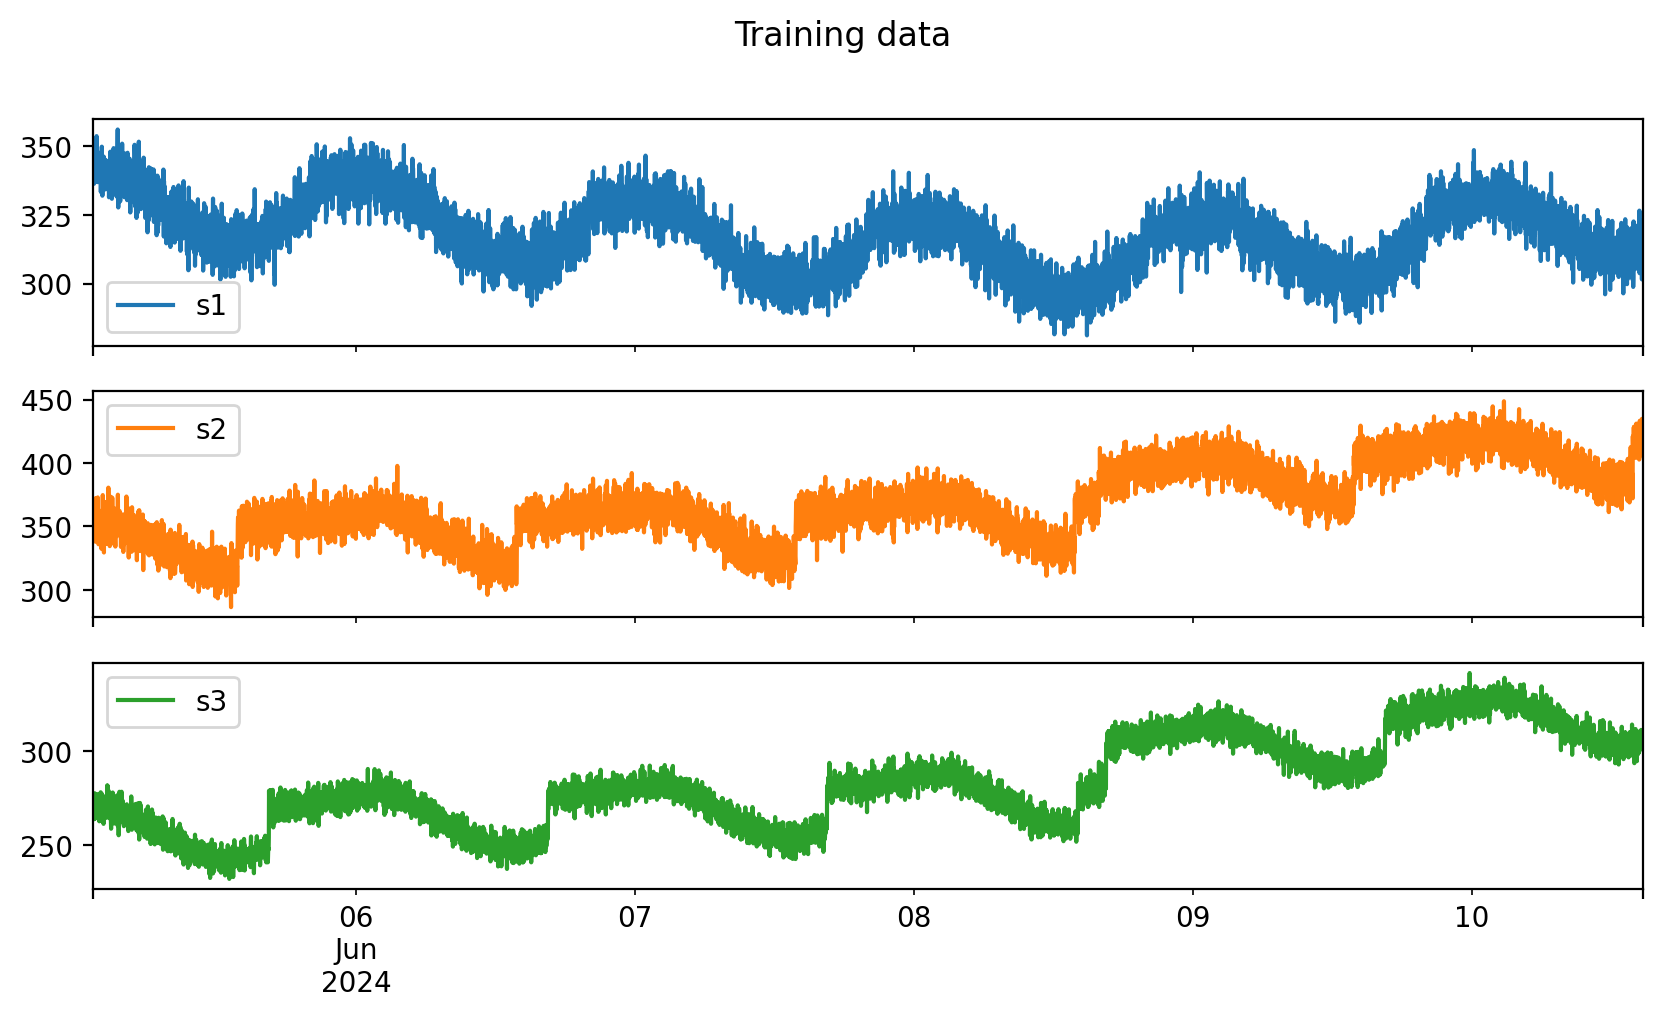

time: 1.69 s (started: 2024-06-12 14:22:56 -07:00)


In [12]:
from numalogic.synthetic import SyntheticTSGenerator, AnomalyGenerator

ts_gen = SyntheticTSGenerator(10000, 3, seasonal_ts_prob=0.9, noise_range=(2, 10))
df = ts_gen.gen_tseries()
train_df, test_df = ts_gen.train_test_split(df, test_size=2000)

train_df.plot(subplots=True, title="Training data")

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

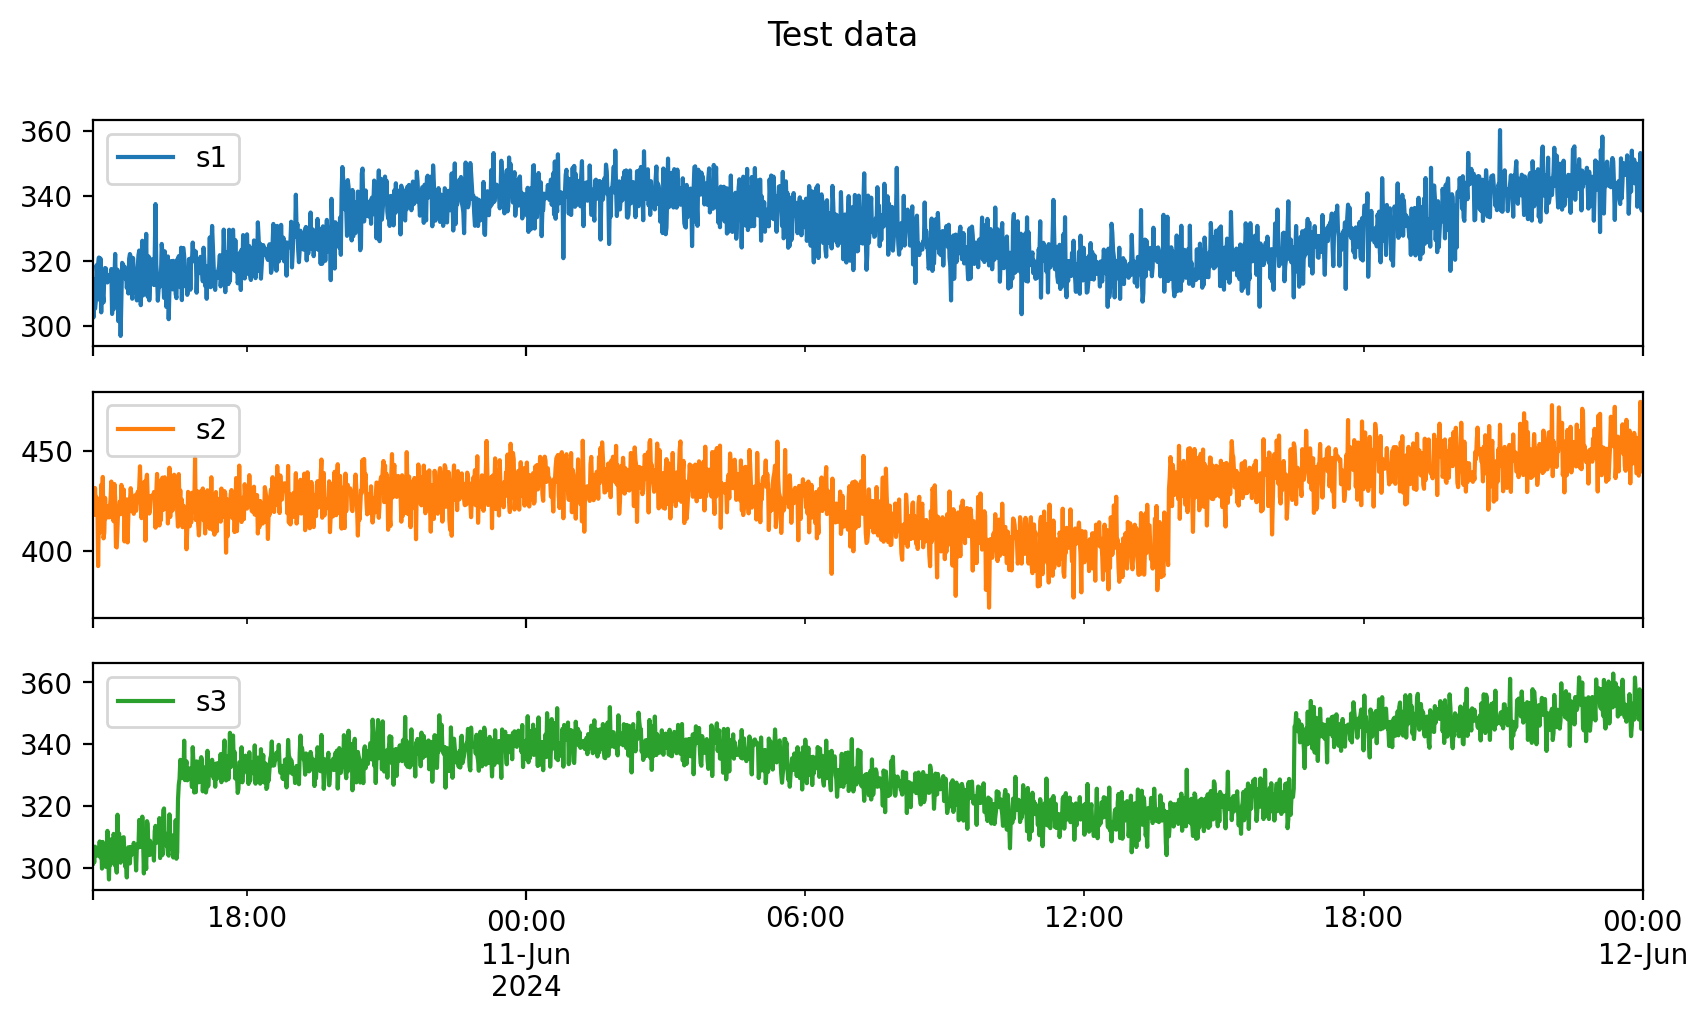

time: 1.02 s (started: 2024-06-12 14:23:23 -07:00)


In [13]:
test_df.plot(subplots=True, title="Test data")

## Inject anomalies in the test set

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

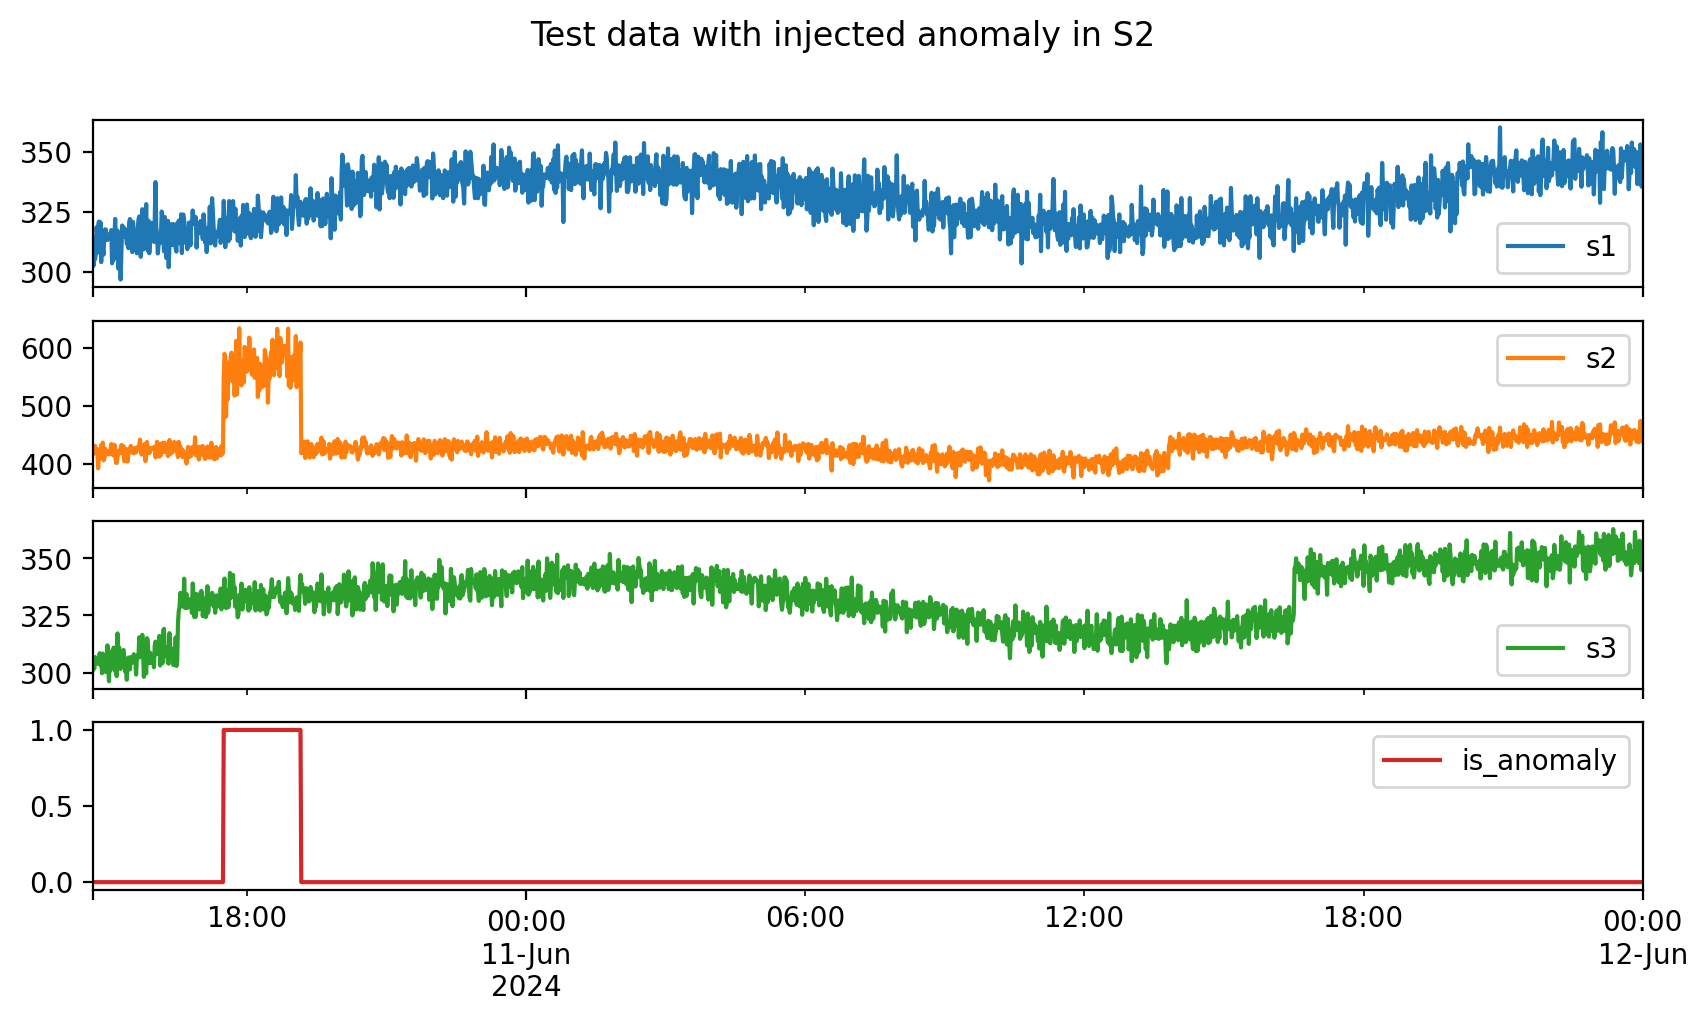

time: 1.27 s (started: 2024-06-12 14:34:39 -07:00)


In [36]:
ano_gen = AnomalyGenerator(train_df, anomaly_ratio=0.05)
anomaly_df = ano_gen.inject_anomalies(test_df, cols=["s2"], impact=3)
anomaly_df.plot(subplots=True, title="Test data with injected anomaly in S2")

# Preprocess the data

In [37]:
from numalogic.transforms import LogTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

tx = make_pipeline(LogTransformer(), MinMaxScaler())
x_train = tx.fit_transform(train_df.to_numpy())
x_test = tx.transform(anomaly_df[["s1", "s2", "s3"]].to_numpy())

time: 1.72 ms (started: 2024-06-12 14:34:43 -07:00)


## 1. Use VanillaAE with 3 features

In [140]:
SEQ_LEN = 10
N_FEATURES = 3
BATCH_SIZE = 512
MAX_EPOCHS = 50

time: 693 µs (started: 2024-06-12 15:53:27 -07:00)


In [141]:
from torch.utils.data import DataLoader
from numalogic.tools.data import StreamingDataset
from numalogic.models.autoencoder import TimeseriesTrainer
from numalogic.models.autoencoder.variants import VanillaAE

train_ds = StreamingDataset(x_train, seq_len=SEQ_LEN)
test_ds = StreamingDataset(x_test, seq_len=SEQ_LEN)

vanilla_ae = VanillaAE(seq_len=SEQ_LEN, n_features=N_FEATURES, loss_fn="mse")
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(vanilla_ae, train_dataloaders=DataLoader(train_ds, batch_size=BATCH_SIZE))

INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=0.2588
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.0846
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.0422
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.0313
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.0257
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.0220
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.0195
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.0172
INFO:numalogic.tools.callbacks:epoch=40,

time: 2.75 s (started: 2024-06-12 15:53:27 -07:00)


[0.01551514 0.02232337 0.01206221] [0.01234407 0.05761655 0.00635742]


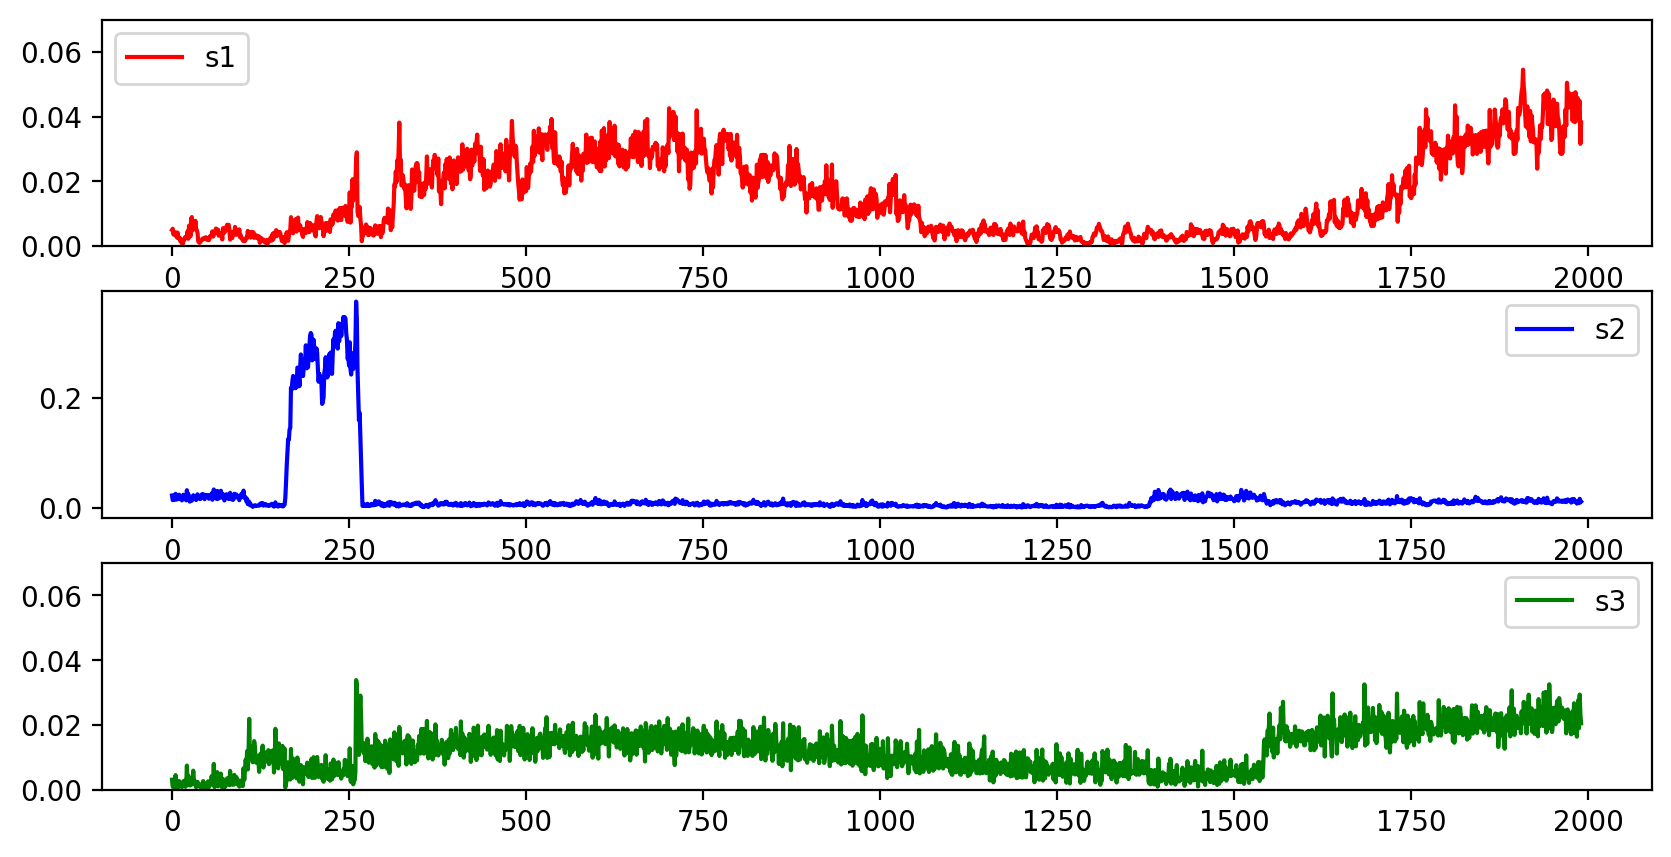

time: 566 ms (started: 2024-06-12 15:53:30 -07:00)


In [142]:
import torch

test_reconerr_1 = trainer.predict(vanilla_ae, dataloaders=DataLoader(test_ds, batch_size=BATCH_SIZE), unbatch=False)
test_reconerr_1 = torch.mean(test_reconerr_1, dim=1).detach().numpy()
_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr_1[:, 0], color="red", label="s1")
ax[0].set_ylim(0, 0.07)
ax[1].plot(test_reconerr_1[:, 1], color="blue", label="s2")
ax[2].plot(test_reconerr_1[:, 2], color="green", label="s3")
ax[2].set_ylim(0, 0.07)
ax[0].legend()
ax[1].legend()
ax[2].legend()
print(np.mean(test_reconerr_1, axis=0), np.std(test_reconerr_1, axis=0))

In [143]:
print(np.mean(test_reconerr_1, axis=0), np.std(test_reconerr_1, axis=0))

[0.01551514 0.02232337 0.01206221] [0.01234407 0.05761655 0.00635742]
time: 3.09 ms (started: 2024-06-12 15:53:33 -07:00)


## 2. VanillaICAE with 3 isolated channels as the features

In [144]:
from numalogic.models.autoencoder.variants import VanillaICAE

vanilla_icae = VanillaICAE(seq_len=SEQ_LEN, n_channels=N_FEATURES, loss_fn="mse")
trainer = TimeseriesTrainer(max_epochs=MAX_EPOCHS, accelerator="cpu", deterministic=True)
trainer.fit(vanilla_icae, train_dataloaders=DataLoader(train_ds, batch_size=BATCH_SIZE))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=0.1433
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.0171
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.0158
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.0140
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.0122
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.0100
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.0086
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.0074
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.0065
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.0059
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.0054
INFO:pytorch_lightning.utilit

time: 2.57 s (started: 2024-06-12 15:53:36 -07:00)


[0.00351116 0.0085931  0.00430065] [0.00143783 0.01916735 0.00250639]


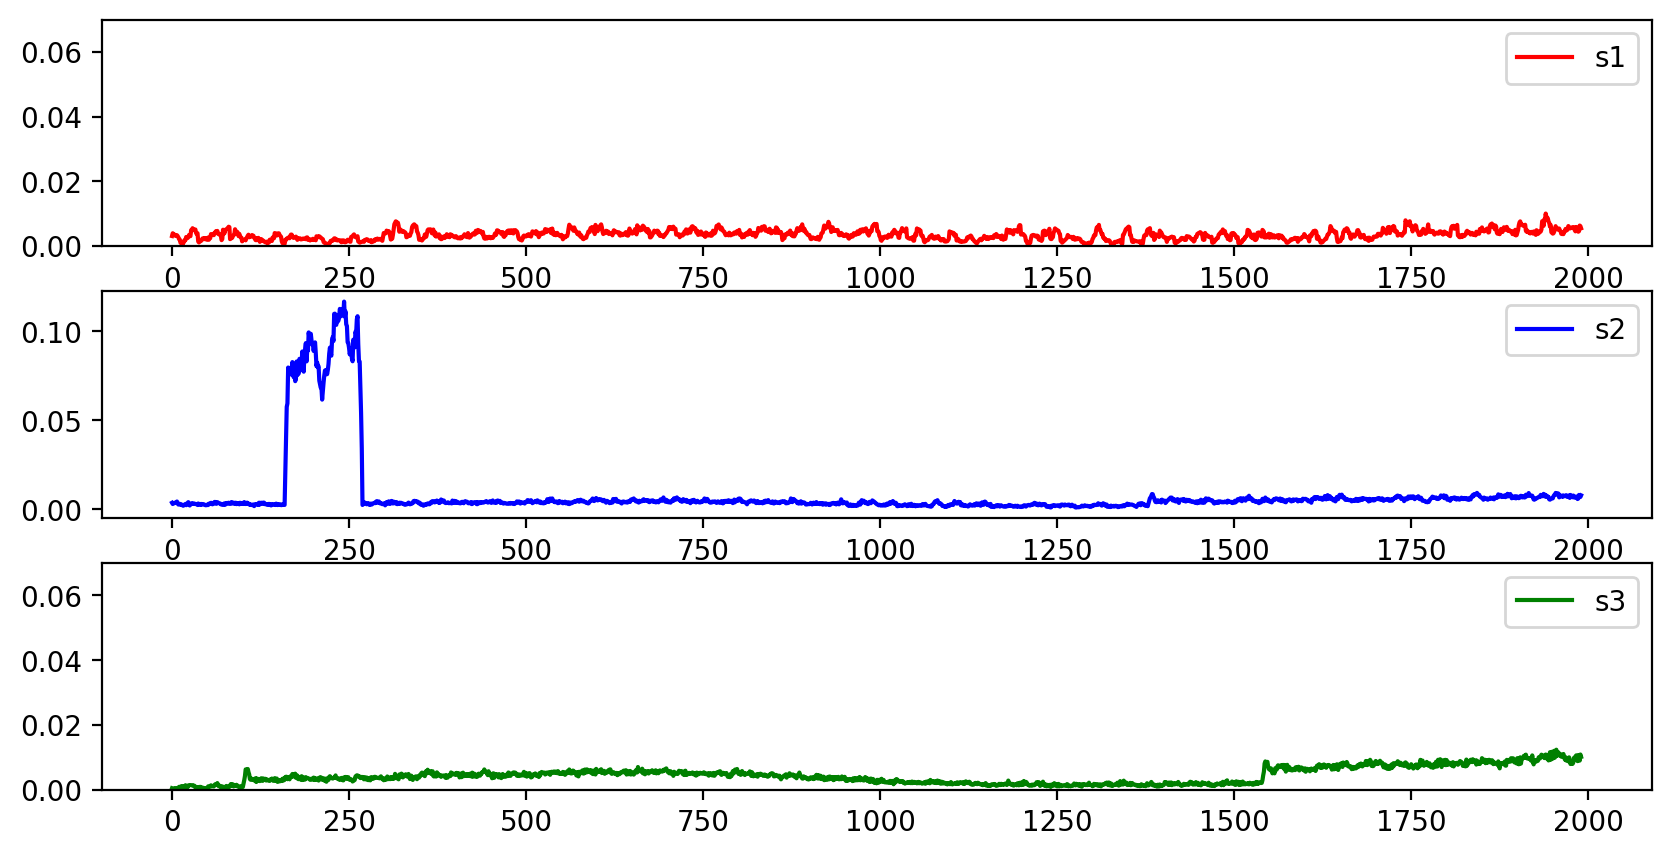

time: 299 ms (started: 2024-06-12 15:53:42 -07:00)


In [145]:
test_reconerr_2 = trainer.predict(vanilla_icae, dataloaders=DataLoader(test_ds, batch_size=BATCH_SIZE), unbatch=False)
test_reconerr_2 = torch.mean(test_reconerr_2, dim=1).detach().numpy()

_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr_2[:, 0], color="red", label="s1")
ax[0].set_ylim(0, 0.07)
ax[1].plot(test_reconerr_2[:, 1], color="blue", label="s2")
ax[2].plot(test_reconerr_2[:, 2], color="green", label="s3")
ax[2].set_ylim(0, 0.07)
ax[0].legend()
ax[1].legend()
ax[2].legend()
print(np.mean(test_reconerr_2, axis=0), np.std(test_reconerr_2, axis=0))

## 3. VanillaAE with only 1 feature
Train the VanillaAE model with only the anomalous feature, i.e. s2

In [146]:
train_ds_s2 = StreamingDataset(x_train[:, [1]], seq_len=SEQ_LEN)
test_ds_s2 = StreamingDataset(x_test[:, [1]], seq_len=SEQ_LEN)
vanilla_ae_s2 = VanillaAE(seq_len=SEQ_LEN, n_features=1, loss_fn="mse")

trainer = TimeseriesTrainer(max_epochs=MAX_EPOCHS, accelerator="cpu", deterministic=True)
trainer.fit(vanilla_ae_s2, train_dataloaders=DataLoader(train_ds_s2, batch_size=BATCH_SIZE))

INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=0.1497
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.0538
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.0336
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.0239
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.0180
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.0152
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.0127
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.0109
INFO:numalogic.tools.callbacks:epoch=40,

time: 2.03 s (started: 2024-06-12 15:53:45 -07:00)


[0.00838758] [0.0173326]


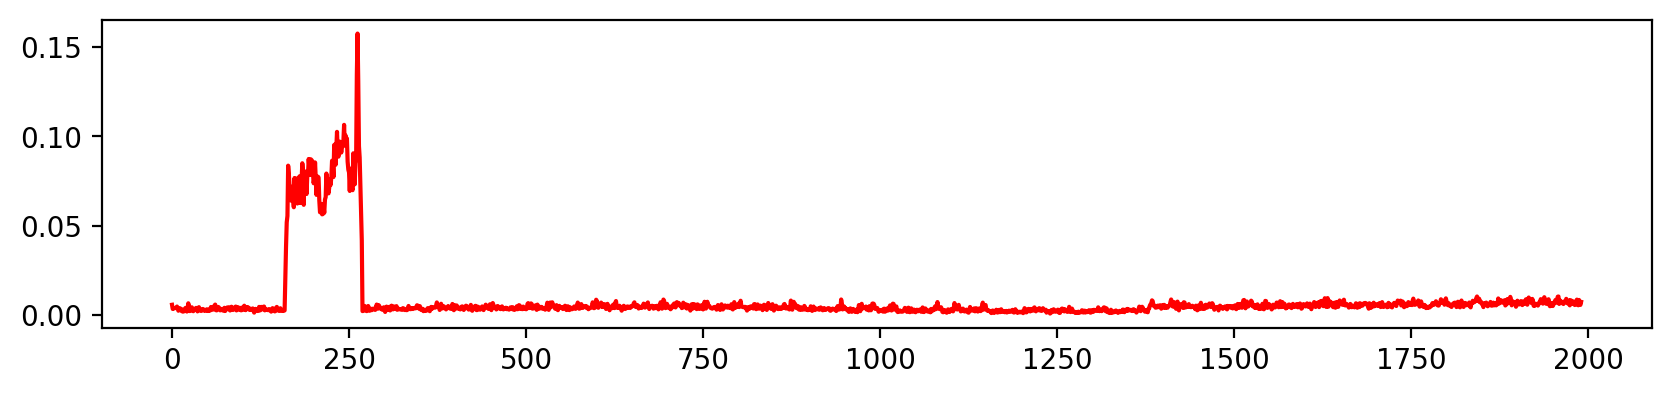

time: 148 ms (started: 2024-06-12 15:53:47 -07:00)


In [147]:
test_reconerr_3 = trainer.predict(vanilla_ae_s2, dataloaders=DataLoader(test_ds_s2, batch_size=BATCH_SIZE),
                                  unbatch=False)
test_reconerr_3 = torch.mean(test_reconerr_3, dim=1).detach().numpy()

_, ax = plt.subplots(figsize=(10, 2))
ax.plot(test_reconerr_3, color="red")
print(np.mean(test_reconerr_3, axis=0), np.std(test_reconerr_3, axis=0))

## Comparing the reconstruction errors for the s2 feature from all 3 models

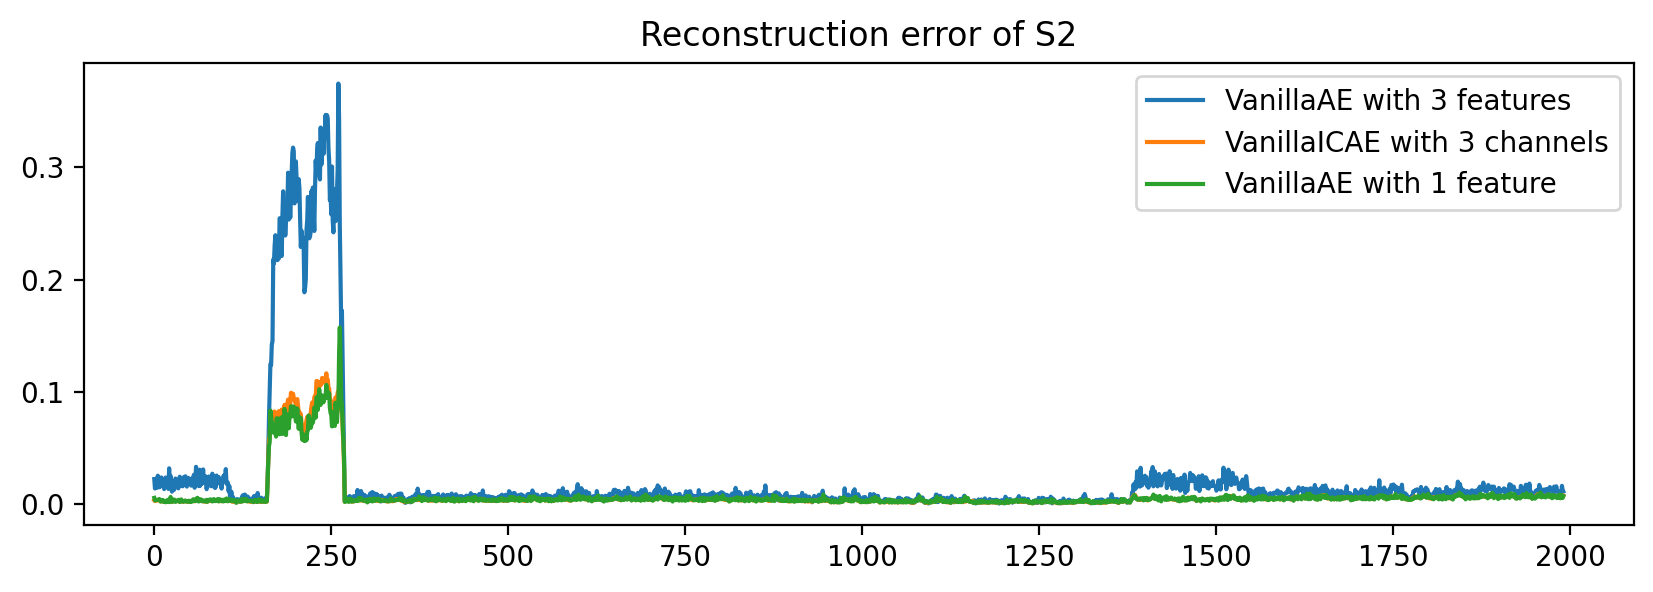

time: 165 ms (started: 2024-06-12 15:53:49 -07:00)


In [148]:
_, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Reconstruction error of S2")
ax.plot(test_reconerr_1[:, 1], label="VanillaAE with 3 features")
ax.plot(test_reconerr_2[:, 1], label="VanillaICAE with 3 channels")
ax.plot(test_reconerr_3, label="VanillaAE with 1 feature")
ax.legend()

Hence, the results show that VanillaICAE uses independent channels in isolation to make sure that each feature/channel is trained independently. Which is why it's scores overlap with the VanillaAE model just trained on the s2 feature.